In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image
from albumentations import pytorch as AT
import albumentations as A
import torchvision.datasets as dataset
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import natsort
%matplotlib inline
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir='/content/drive/My Drive/Wheat_Growth_Stage/train'
test_dir='/content/drive/My Drive/Wheat_Growth_Stage/test'
submission=pd.read_csv('/content/drive/My Drive/Wheat_Growth_Stage/SampleSubmission.csv')
image_label='/content/drive/My Drive/Wheat_Growth_Stage/Train.csv'
train_files=os.listdir(train_dir)
test_files=os.listdir(test_dir)
labels=pd.read_csv(image_label)
train_files_q2=[]
for filee in train_files:
  if filee.split('.')[0] in labels[labels['label_quality']==2]['UID'].unique():
    train_files_q2.append(filee)

In [ ]:
len(train_files_q2)

2856

In [ ]:
#with zipfile.ZipFile('/content/drive/My Drive/Wheat_Growth_Stage/train.zip', 'r') as zip_ref:
  #zip_ref.extractall('/content/drive/My Drive/Wheat_Growth_Stage')
#with zipfile.ZipFile('/content/drive/My Drive/Wheat_Growth_Stage/test.zip', 'r') as zip_ref:
  #zip_ref.extractall('/content/drive/My Drive/Wheat_Growth_Stage')

In [ ]:
class DatasetRetriever(Dataset):
  def __init__(self, dir,image_list,labels, transform=None,mode='train'):
        self.dir = dir
        self.labels = pd.read_csv(labels)
        self.labels['growth_stage']=self.labels['growth_stage'].map({1:0,2:1,3:2,4:3,5:4,6:5,7:6})
        self.transform=transform
        self.image_list=image_list
        self.label=0
        self.mode=mode
        self.image=None
        self.image_name=None
        self.full_path=None

  def __len__(self):
        return len(self.image_list)

  def __getitem__(self, idx: int):       
        self.image_name = self.image_list[idx]
        self.full_path = os.path.join(self.dir, self.image_name)
        if self.mode=='train':
            if self.image_name.split('.')[0] in self.labels['UID'].unique():
                self.image = cv2.imread(self.full_path)
                self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
                self.label= int(self.labels[self.labels['UID']==self.image_name.split('.')[0]]['growth_stage'].values)
        else:
            self.image = cv2.imread(self.full_path)
            self.image = cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=self.image)
            self.image = augmented['image']
        if self.mode == 'train':
            return self.image, self.label
        else:
            return self.image, self.image_name.split('.')[0]

        

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

2

In [ ]:
batch_size = 32
num_workers = multiprocessing.cpu_count()
img_size = 256

In [ ]:
data_transforms = A.Compose([
    A.Resize(500, 200),                         
    A.augmentations.transforms.HorizontalFlip(p=0.5),
    #A.Crop(x_min=int(3*img_size/10),x_max=int(7*img_size/10),y_min=int(*img_size/10),y_max=int(6*img_size/10)),
    A.CenterCrop(300,150),
    A.Resize(img_size, img_size),
    #A.Normalize(mean=(-0.491,-0.0869,-0.9765),std=(0.6966,0.544,0.575)),
    AT.ToTensor()
    ])

data_transforms_test = A.Compose([
    A.Resize(500, 200),
    #A.Crop(x_min=int(2*img_size/10),x_max=int(8*img_size/10),y_min=int(2*img_size/10),y_max=int(8*img_size/10)),
    #A.Crop(x_min=int(10*img_size/70),x_max=int(60*img_size/50),y_min=int(10*img_size/70),y_max=int(60*img_size/70)),
    A.CenterCrop(300,150),
    A.Resize(img_size, img_size),
    #A.Normalize(),
    AT.ToTensor()
    ])

In [ ]:
trainset = DatasetRetriever(train_dir, train_files_q2,image_label, transform = data_transforms)
testset = DatasetRetriever(test_dir, test_files,image_label,transform=data_transforms_test, mode = "test")

In [ ]:
len(testset)

3558

In [ ]:
len(trainset)

2856

In [ ]:
valid_size = int(len(train_files_q2) * 0.08)
indices = torch.randperm(len(trainset)) #создадим лист индексов
#определим подвыборки для трейн и валидации
train_indices = indices[:len(indices)-valid_size] 
valid_indices = indices[len(indices)-valid_size:]

#создаем даталоадеры для всех 3х подвыборок.
trainloader = torch.utils.data.DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size,
                                        sampler=SubsetRandomSampler(train_indices))
validloader = torch.utils.data.DataLoader(trainset, pin_memory=True, 
                                        batch_size=batch_size,
                                        sampler=SubsetRandomSampler(valid_indices))

testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size,
                                         num_workers = num_workers)

In [ ]:
len(valid_indices)

228

In [ ]:
len(trainloader),len(validloader),len(testloader)

(83, 8, 112)

In [ ]:
len(valid_indices)

228

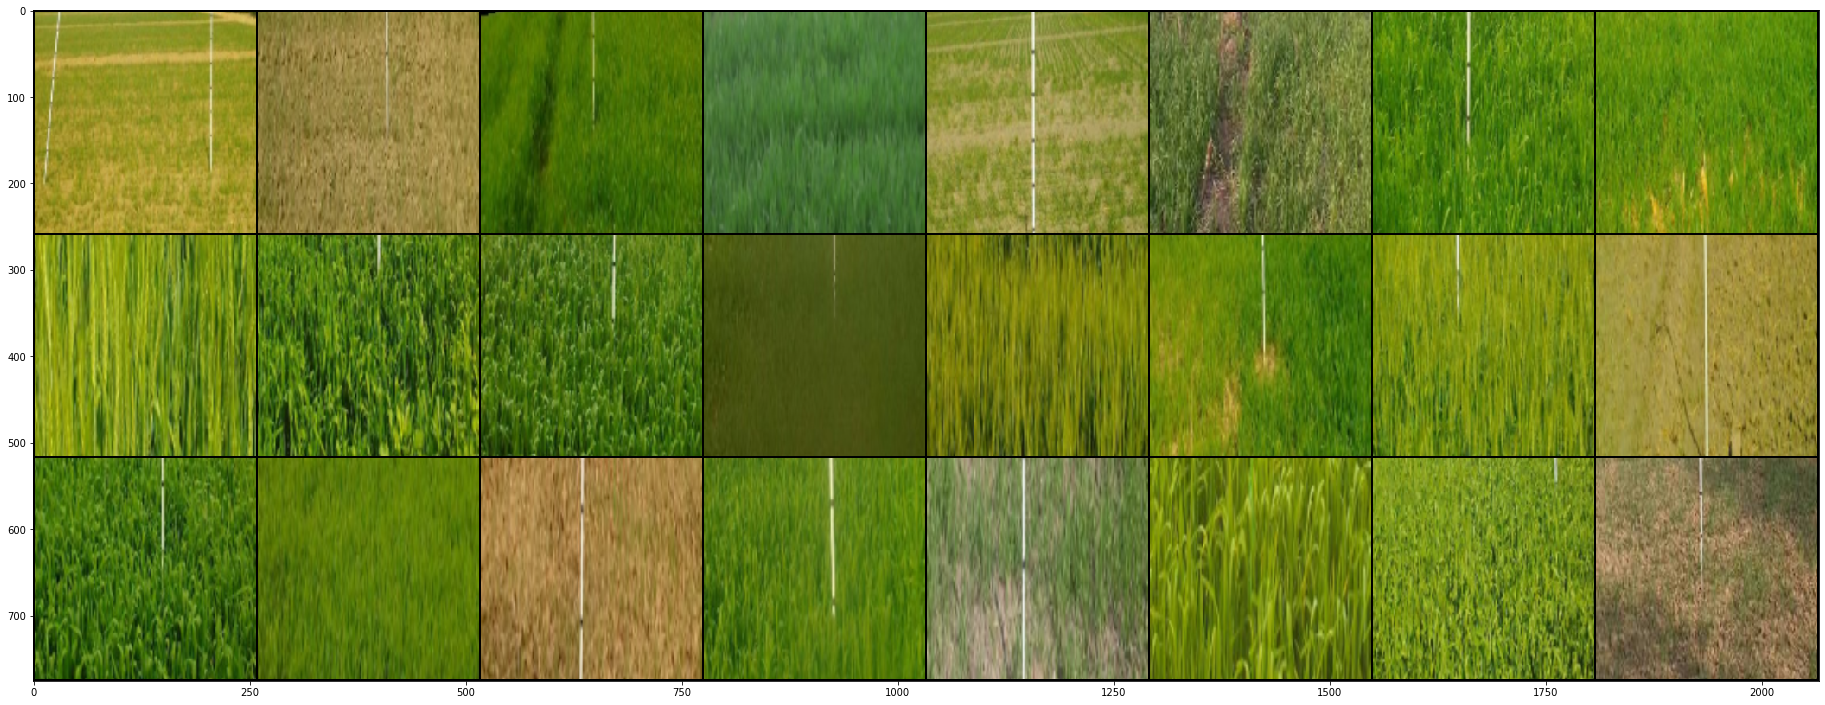

In [ ]:
samples, labels = next(iter(trainloader))
plt.figure(figsize=(32,48))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')

In [ ]:
labels

tensor([1, 1, 3, 3, 1, 2, 3, 2, 6, 3, 4, 2, 6, 2, 6, 1, 3, 3, 1, 6, 2, 3, 3, 1,
        3, 3, 3, 3, 1, 1, 3, 4])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
model = torchvision.models.resnet50(pretrained=False,progress=True)

In [ ]:
#torch.cuda.empty_cache()
!nvidia-smi

Mon Aug 31 18:32:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |    895MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
in_features = model.fc.in_features
model.fc=nn.Linear(in_features, 7)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, sheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 15
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
          print(time.ctime(), 'Epoch:', epoch)
          b_i=0
          train_loss = []

          for batch_i, (data, target) in enumerate(train_loader):
              b_i+=1
              data, target = data.to(device), target.to(device)
              optimizer.zero_grad()
              output = model_conv(data)
              loss = criterion(output, target)
              train_loss.append(loss.item())
              loss.backward()
              optimizer.step()
              if b_i % 10 == 0: 
                  print(b_i)
      # запускаем валидацию
          model_conv.eval()
          val_loss = []
          for batch_i, (data, target) in enumerate(valid_loader):
              data, target = data.to(device), target.to(device)
              output = model_conv(data)
              loss = criterion(output, target)
              val_loss.append(loss.item()) 

          print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, lr: {optimizer.param_groups[0]['lr']}")

          valid_loss = np.mean(val_loss)
          sheduler.step(valid_loss)
          if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              torch.save(model_conv.state_dict(), '/content/drive/My Drive/Wheat_Growth_Stage/model4_resnet50_RMS0.01_continue.pt')
              
              valid_loss_min = valid_loss
              p = 0

          # проверяем как дела на валидации
          if valid_loss > valid_loss_min:
              p += 1
              
              print(f'{p} epochs of increasing val loss')
              if p > patience:
                  print('Stopping training')
                  stop = True
                  break        

          if stop:
              break

        
    return model_conv, train_loss, val_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)#,momentum=0.9,nesterov=True,lr=0.1)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9,nesterov=True)
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [ ]:
model_resnet, train_loss, val_loss = train_model(model, trainloader, validloader, criterion, 
                              optimizer, scheduler, n_epochs=200)

Mon Aug 31 19:42:06 2020 Epoch: 1
10
20
30
40
50
60
70
80
Epoch 1, train loss: 0.7569, valid loss: 0.9268, lr: 0.001
Validation loss decreased (inf --> 0.926816).  Saving model ...
Mon Aug 31 19:42:51 2020 Epoch: 2
10
20
30
40
50
60
70
80
Epoch 2, train loss: 0.6936, valid loss: 0.8563, lr: 0.001
Validation loss decreased (0.926816 --> 0.856291).  Saving model ...
Mon Aug 31 19:43:36 2020 Epoch: 3
10
20
30
40
50
60
70
80
Epoch 3, train loss: 0.6807, valid loss: 0.8640, lr: 0.001
1 epochs of increasing val loss
Mon Aug 31 19:44:20 2020 Epoch: 4
10
20
30
40
50
60
70
80
Epoch 4, train loss: 0.6718, valid loss: 0.8258, lr: 0.001
Validation loss decreased (0.856291 --> 0.825754).  Saving model ...
Mon Aug 31 19:45:06 2020 Epoch: 5
10
20
30
40
50
60
70
80
Epoch 5, train loss: 0.6705, valid loss: 0.8887, lr: 0.001
1 epochs of increasing val loss
Mon Aug 31 19:45:50 2020 Epoch: 6
10
20
30
40
50
60
70
80
Epoch 6, train loss: 0.6492, valid loss: 0.8234, lr: 0.001
Validation loss decreased (0.825

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/Wheat_Growth_Stage/model4_resnet50_RMS0.01.pt'))

<All keys matched successfully>

In [ ]:
correct=0
model.to(device)
model.eval()
with torch.no_grad():
  for data, target in validloader:
    data = data.to(device=device)
    target = target.to(device=device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum().item()


acc = correct / 228
print(f'Accuracy on test set: {acc}')

Accuracy on test set: 0.6535087719298246


In [ ]:
valid_indices.shape

torch.Size([1069])

In [ ]:
22*45

990

In [ ]:
import torch.nn.functional as F
model.to(device)
model.eval()
pred_list = []
names_list = []
i=0
for images, image_names in testloader:
    with torch.no_grad():
        print(i)
        i=i+1
        images = images.to(device)
        output = model(images)
        pred = F.softmax(output)
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        pred_list += [p.item() for p in pred]
        names_list += [name for name in image_names]


submission.UID = names_list
submission.growth_stage = pred_list
submission['growth_stage']=submission['growth_stage'].map({0: '1', 1: '2',2:'3',3:'4',4:'5',5:'6',6:'7'})
submission.to_csv('submission1_resnet101_sgd0.1.csv', index=False)

0
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
